In [1]:
from IPython.display import YouTubeVideo
import cv2
import numpy as np
import os
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output # Extra

%matplotlib inline
# Open a new thread to manage the external cv2 interaction
cv2.startWindowThread()

def plt_show(image, title=""):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.title(title)
    plt.imshow(image, cmap="Greys_r")
    plt.show()

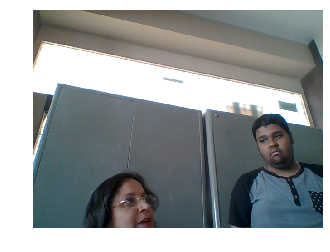

In [2]:
webcam = cv2.VideoCapture(0)
_, frame = webcam.read()
webcam.release()
plt_show(frame)  

In [3]:
detector = cv2.CascadeClassifier("E:/Projects/Miniproject/Face_Recon_Real_time/frontal_face.xml")

print(detector.empty())

scale_factor = 1.2
min_neighbors = 5
min_size = (30, 30)
biggest_only = True
flags = cv2.CASCADE_FIND_BIGGEST_OBJECT | \
            cv2.CASCADE_DO_ROUGH_SEARCH if biggest_only else \
            cv2.CASCADE_SCALE_IMAGE
        
faces_coord = detector.detectMultiScale(frame,
                                        scaleFactor=scale_factor,
                                        minNeighbors=min_neighbors,
                                        minSize=min_size)
print ("Type: " + str(type(faces_coord)))
print (faces_coord)
print ("Length: " + str(len(faces_coord)) )

False
Type: <class 'numpy.ndarray'>
[[483 247  87  87]]
Length: 1


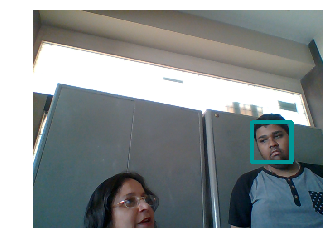

In [4]:
# Draw a rectangle Around the Face
for (x, y, w, h) in faces_coord:
    cv2.rectangle(frame, (x, y), (x + w, y + h), (150, 150, 0), 8)
plt_show(frame) 

In [5]:
class FaceDetector(object):
    def __init__(self, xml_path):
        self.classifier = cv2.CascadeClassifier(xml_path)
    
    def detect(self, image, biggest_only=True):
        scale_factor = 1.2
        min_neighbors = 5
        min_size = (30, 30)
        biggest_only = True
        flags = cv2.CASCADE_FIND_BIGGEST_OBJECT | \
                    cv2.CASCADE_DO_ROUGH_SEARCH if biggest_only else \
                    cv2.CASCADE_SCALE_IMAGE
        faces_coord = self.classifier.detectMultiScale(image,
                                                       scaleFactor=scale_factor,
                                                       minNeighbors=min_neighbors,
                                                       minSize=min_size,
                                                       flags=flags)
        return faces_coord

In [6]:
class VideoCamera(object):
    def __init__(self, index=0):
        self.video = cv2.VideoCapture(index)
        self.index = index
        print (self.video.isOpened())

    def __del__(self):
        self.video.release()
    
    def get_frame(self, in_grayscale=False):
        _, frame = self.video.read()
        if in_grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return frame

In [7]:
webcam = VideoCamera()
detector = FaceDetector("E:/Projects/Miniproject/Face_Recon_Real_time/frontal_face.xml")

True


In [8]:
try:
    while True:
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame)
        for (x, y, w, h) in faces_coord:
            cv2.rectangle(frame, (x, y), (x + w, y + h), 
                          (150, 150, 0), 8)
        plt_show(frame) 
        clear_output(wait = True)
except KeyboardInterrupt:
     print ("Live Video Interrupted")

Live Video Interrupted


In [9]:

def cut_faces(image, faces_coord):
    faces = []
      
    for (x, y, w, h) in faces_coord:
        w_rm = int(0.2 * w / 2)
        faces.append(image[y: y + h, x + w_rm: x + w - w_rm])
         
    return faces

In [10]:
try:
    while True:
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame)
        if len(faces_coord):
            faces = cut_faces(frame, faces_coord)
            plt_show(faces[0])
            clear_output(wait = True)
except KeyboardInterrupt:
     print ("Live Video Interrupted")

Live Video Interrupted


In [11]:
def normalize_intensity(images):
    images_norm = []
    for image in images:
        is_color = len(image.shape) == 3 
        if is_color:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images_norm.append(cv2.equalizeHist(image))
    return images_norm

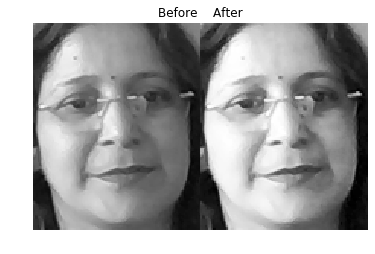

In [12]:
face_bw = cv2.cvtColor(faces[0], cv2.COLOR_BGR2GRAY)
face_bw_eq = cv2.equalizeHist(face_bw)
plt_show(np.hstack((face_bw, face_bw_eq)), "Before    After") 

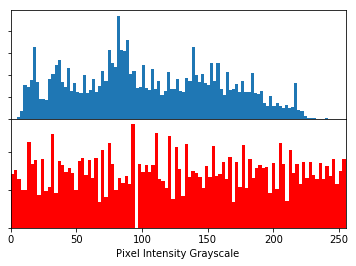

In [13]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
ax1.hist(face_bw.flatten(),100)
ax2.hist(face_bw_eq.flatten(),100, color = 'r')
ax1.set_xlim([0,255])
# ax1.set_ylim([0,1000])
ax2.set_xlim([0, 255])
# ax2.set_ylim([0, 700])
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax2.set_xlabel('Pixel Intensity Grayscale')
f.subplots_adjust(hspace=0) 
plt.show()

In [14]:
try:
    while True:
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame)
        if len(faces_coord): 
            faces = cut_faces(frame, faces_coord)
            faces = normalize_intensity(faces)
            plt_show(faces[0])
            clear_output(wait = True)
except KeyboardInterrupt:
     print ("Live Video Interrupted")

Live Video Interrupted


In [15]:
def resize(images, size=(50, 50)):
    images_norm = []
    for image in images:
        if image.shape < size:
            image_norm = cv2.resize(image, size, 
                                    interpolation = cv2.INTER_AREA)
        else:
            image_norm = cv2.resize(image, size, 
                                    interpolation = cv2.INTER_CUBIC)
        images_norm.append(image_norm)

    return images_norm 

In [16]:
try:
    while True:
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame)
        if len(faces_coord):
            faces = cut_faces(frame, faces_coord)
            faces = normalize_intensity(faces)
            faces = resize(faces)
            plt_show(faces[0])
            clear_output(wait = True)
except KeyboardInterrupt:
     print ("Live Video Interrupted")

Live Video Interrupted


In [17]:
def normalize_faces(frame, faces_coord):
    faces = cut_faces(frame, faces_coord)
    faces = normalize_intensity(faces)
    faces = resize(faces)
    return faces

def draw_rectangle(image, coords):
    for (x, y, w, h) in coords:
        w_rm = int(0.2 * w / 2) 
        cv2.rectangle(image, (x + w_rm, y), (x + w - w_rm, y + h), 
                              (150, 150, 0), 8)

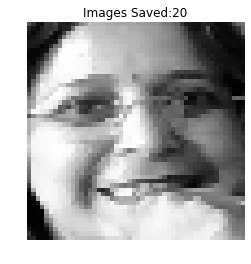

In [18]:
folder = "people/" + input('Person: ').lower() # input name
cv2.namedWindow("PyData Tutorial", cv2.WINDOW_AUTOSIZE)
if not os.path.exists(folder):
    os.mkdir(folder)
    counter = 1
    timer = 0
    while counter < 21 : # take 20 pictures
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame) # detect
        if len(faces_coord) and timer % 700 == 50: # every Second or so
            faces = normalize_faces(frame, faces_coord) # norm pipeline
            cv2.imwrite(folder + '/' + str(counter) + '.jpg', faces[0])
            plt_show(faces[0], "Images Saved:" + str(counter))
            clear_output(wait = True) # saved face in notebook
            counter += 1
        draw_rectangle(frame, faces_coord) # rectangle around face
        cv2.imshow("PyData Tutorial", frame) # live feed in external
        cv2.waitKey(50)
        timer += 50
    cv2.destroyAllWindows()
else:
    print ("This name already exists.")

In [19]:
del webcam